In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
np.random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
dataset_train = torchvision.datasets.MNIST(root='', train=True, transform=transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST(root='', train=False, transform=transforms.ToTensor())

In [4]:
# hyperparameters

lr = 0.01
training_epochs = 15
batch_size = 100

In [5]:
relu = nn.ReLU()

model_without_bn = nn.Sequential(nn.Linear(28*28, 256), relu,
                                 nn.Linear(256, 256), relu,
                                 nn.Linear(256, 10)).to(device)

model_with_bn = nn.Sequential(nn.Linear(28*28, 256), nn.BatchNorm1d(256), relu,
                              nn.Linear(256, 256), nn.BatchNorm1d(256), relu,
                              nn.Linear(256, 10)).to(device)

In [6]:
optimizer_without_bn = torch.optim.Adam(model_without_bn.parameters(), lr=lr)
optimizer_with_bn = torch.optim.Adam(model_with_bn.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

In [7]:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

print('Start training...')

for epoch in range(1, training_epochs+1):
    
    model_without_bn.train() # batchnormalization train mode
    model_with_bn.train()
    
    running_loss_without_bn = 0
    running_correct_without_bn = 0
    running_loss_with_bn = 0
    running_correct_with_bn = 0

    for X, y in dataloader_train:
        X, y = X.view(-1,28*28).to(device), y.to(device)
        
        # without bn
        y_pred = model_without_bn(X)
        loss = criterion(y_pred, y)

        optimizer_without_bn.zero_grad()
        loss.backward()
        optimizer_without_bn.step()

        with torch.no_grad():
            running_loss_without_bn += loss.item()
            running_correct_without_bn += sum(y_pred.argmax(dim=1) == y).item()
        
        # with bn
        y_pred = model_with_bn(X)
        loss = criterion(y_pred, y)

        optimizer_with_bn.zero_grad()
        loss.backward()
        optimizer_with_bn.step()

        with torch.no_grad():
            running_loss_with_bn += loss.item()
            running_correct_with_bn += sum(y_pred.argmax(dim=1) == y).item()

    running_test_loss_without_bn = 0
    running_test_correct_without_bn = 0
    running_test_loss_with_bn = 0
    running_test_correct_with_bn = 0
    
    with torch.no_grad():
        model_without_bn.eval() # batchnormalization test mode
        model_with_bn.eval()
        for X, y in dataloader_test:
            X, y = X.view(-1,28*28).to(device), y.to(device)
            
            # without bn
            y_pred = model_without_bn(X)
            loss = criterion(y_pred, y)

            running_test_loss_without_bn += loss.item()
            running_test_correct_without_bn += sum(y_pred.argmax(dim=1) == y).item()
            
            # with bn
            y_pred = model_with_bn(X)
            loss = criterion(y_pred, y)

            running_test_loss_with_bn += loss.item()
            running_test_correct_with_bn += sum(y_pred.argmax(dim=1) == y).item()
    
    train_losses.append([running_loss_without_bn/len(dataloader_train),
                         running_loss_with_bn/len(dataloader_train)])
    train_accs.append([running_correct_without_bn/len(dataloader_train),
                       running_correct_with_bn/len(dataloader_train)])
    valid_losses.append([running_test_loss_without_bn/len(dataloader_test),
                         running_test_loss_with_bn/len(dataloader_test)])
    valid_accs.append([running_test_correct_without_bn/len(dataloader_test),
                       running_test_correct_with_bn/len(dataloader_test)])

    print(f'without bn\
    epoch {epoch}\
    training loss:{running_loss_without_bn/len(dataloader_train):.3f}\
    training acc:{running_correct_without_bn/len(dataloader_train):.3f}\
    test loss:{running_test_loss_without_bn/len(dataloader_test):.3f}\
    test acc:{running_test_correct_without_bn/len(dataloader_test):.3f}')
    print(f'with bn\
    epoch {epoch}\
    training loss:{running_loss_with_bn/len(dataloader_train):.3f}\
    training acc:{running_correct_with_bn/len(dataloader_train):.3f}\
    test loss:{running_test_loss_with_bn/len(dataloader_test):.3f}\
    test acc:{running_test_correct_with_bn/len(dataloader_test):.3f}')
    print()

print('Finished Training')

Start training...
without bn    epoch 1    training loss:0.238    training acc:92.837    test loss:0.168    test acc:95.350
with bn    epoch 1    training loss:0.192    training acc:93.932    test loss:0.095    test acc:97.080

without bn    epoch 2    training loss:0.147    training acc:95.837    test loss:0.133    test acc:96.420
with bn    epoch 2    training loss:0.091    training acc:97.178    test loss:0.092    test acc:97.140

without bn    epoch 3    training loss:0.119    training acc:96.632    test loss:0.156    test acc:96.380
with bn    epoch 3    training loss:0.067    training acc:97.805    test loss:0.079    test acc:97.510

without bn    epoch 4    training loss:0.103    training acc:97.153    test loss:0.138    test acc:96.630
with bn    epoch 4    training loss:0.053    training acc:98.297    test loss:0.075    test acc:97.810

without bn    epoch 5    training loss:0.090    training acc:97.505    test loss:0.141    test acc:97.030
with bn    epoch 5    training loss:

In [8]:
def plot_compare(history, ylim=None, title=None):
    
    history = np.array(history)
    x = np.arange(training_epochs) + 1
    plt.figure(figsize=(10, 5))
    plt.plot(history[:,0], label='Without BN')
    plt.plot(history[:,1], label='With BN')

    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)

    plt.legend()
    plt.grid('on')
    plt.show()

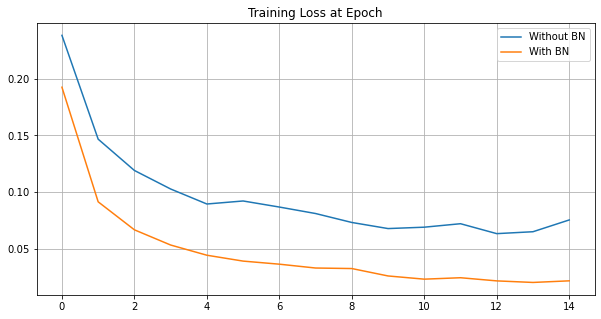

In [9]:
plot_compare(train_losses, title='Training Loss at Epoch')

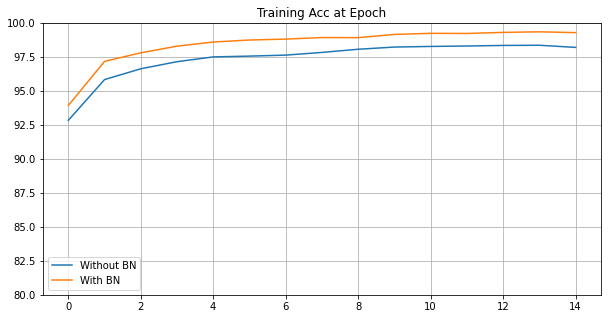

In [10]:
plot_compare(train_accs, [80, 100], title='Training Acc at Epoch')

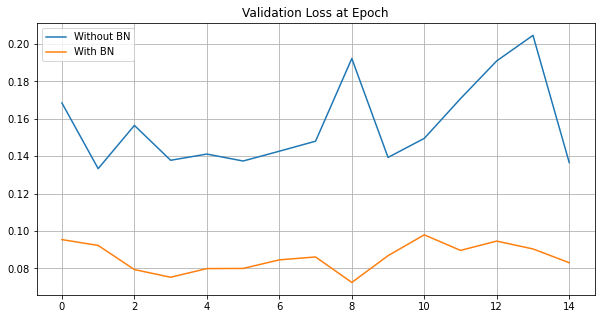

In [11]:
plot_compare(valid_losses, title='Validation Loss at Epoch')

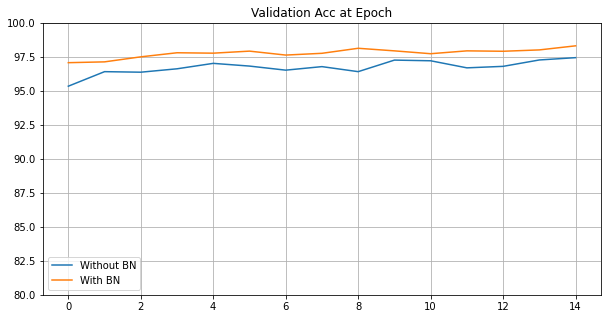

In [12]:
plot_compare(valid_accs, [80, 100], title='Validation Acc at Epoch')